In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import datetime as dt
from datetime import datetime
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
data_BID = pd.read_csv('/content/drive/MyDrive/PTTK/CNN_LSTM/STB_notebook/STB Historical Data.csv')
df1 = data_BID.reset_index()['Price']
df1

0       13400
1       13350
2       13600
3       13600
4       14550
        ...  
1487    27100
1488    26300
1489    26600
1490    26950
1491    26600
Name: Price, Length: 1492, dtype: int64

In [ ]:
# 2. Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
# 3. Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
print("Train size: {}".format(train_size))
print("Test size: {}".format(test_size))

train_data = df1[:train_size]
test_data = df1[train_size:]

Train size: 1044
Test size: 448


In [ ]:
# 4. Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step -1 ):
    #for i in range(len(dataset) - time_step ):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print("X_train.shape = {}  y_train.shape = {}".format(X_train.shape, y_train.shape))
print("X_test,shape = {} y_test.shape = {}".format(X_test.shape, y_test.shape))

X_train.shape = (943, 100)  y_train.shape = (943,)
X_test,shape = (347, 100) y_test.shape = (347,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1, time_step, 1)
X_test = X_test.reshape(X_test.shape[0], -1, time_step, 1)
X_train.shape, X_test.shape

((943, 1, 100, 1), (347, 1, 100, 1))

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, time_step, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(time_step, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse', 'mae'])
# fit model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)


Epoch 1/150
30/30 [==============================] - 3s 23ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0831
Epoch 2/150
30/30 [==============================] - 1s 22ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0427
Epoch 3/150
30/30 [==============================] - 1s 22ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0342
Epoch 4/150
30/30 [==============================] - 1s 22ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0300
Epoch 5/150
30/30 [==============================] - 1s 22ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0281
Epoch 6/150
30/30 [==============================] - 1s 22ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0256
Epoch 7/150
30/30 [==============================] - 1s 23ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0235
Epoch 8/150
30/30 [==============================] - 1s 22ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0237
Epoch 9/150
30/30 [==============================] - 1s 24ms/step - loss: 9.9987e-04 - mse: 9.9987e-04 - mae: 0.0218
Epoch 10/15

In [ ]:
model.save("model1.keras")

In [ ]:
new_model = tf.keras.models.load_model("./model1.keras")

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 98, 64)      256       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 49, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 3136)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               1294800   
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

11/11 [==============================] - 0s 8ms/step


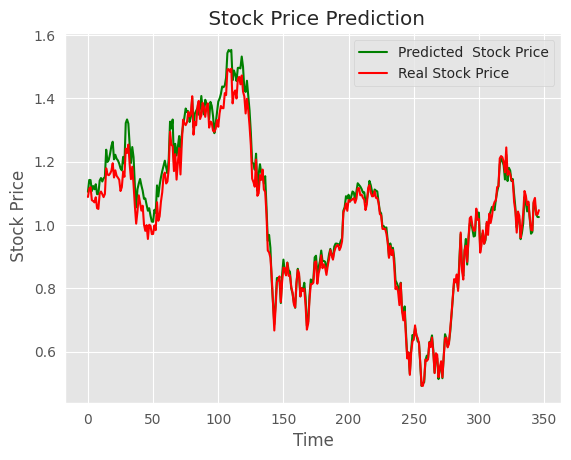

In [ ]:
#Predict the test set
predicted  = new_model.predict(X_test)
test_label = y_test.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(X_train)
for j in range(len_t , len_t + len(X_test)):
    temp = df1[j,0]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [ ]:
# 8. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 7ms/step


In [ ]:
# 9. Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# 10. Evaluate Model with RMSE
test_rmse = np.sqrt(np.mean((test_predict - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2))
print('Testing RMSE:', test_rmse)


Testing RMSE: 13394.63077098802


In [ ]:
# 11. Forecast Next 30 Days
last_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((-1, 1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((-1, 1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

# The rest of your code remains the same
# ...


Testing RMSE: 13394.63077098802
Testing MAE: 11356.464717515531
Testing MAPE: 29.55645338392707


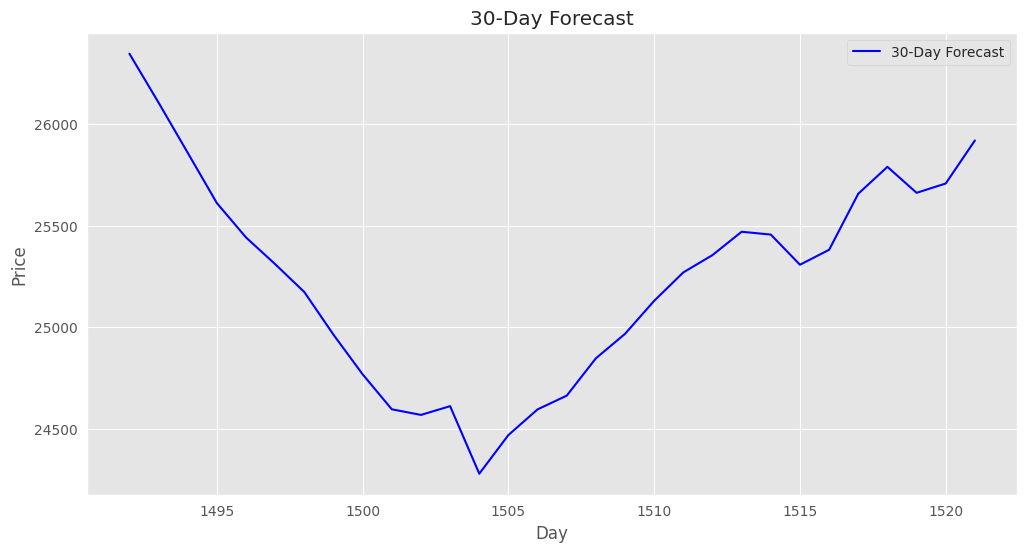

In [ ]:
# Assuming 'lst_output' contains your 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)

# Plotting the 30-day forecast
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, color='blue')
plt.title('30-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['30-Day Forecast'])
plt.show()


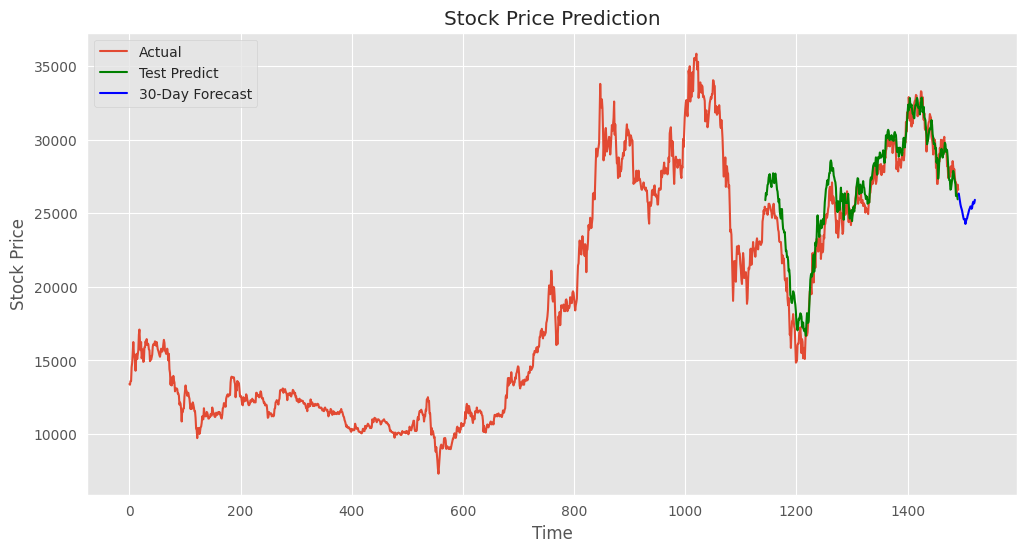

In [ ]:
# Step 12: Plot Results with Train and Test Predictions

plt.figure(figsize=(12, 6))

# Plot entire dataset
plt.plot(scaler.inverse_transform(df1), label='Actual')

# Plot training predictions
train_predict_plot = np.empty_like(df1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
#plt.plot(train_predict_plot, label='Train Predict', color='orange')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Test Predict', color='green')

# Plot 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, label='30-Day Forecast', color='blue')

# Adding legends and labels
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
